# Direct S-Matrix-based Method - 2.5Mhz

> This notebook explores and implements a multi-output Convolutional Neural Networks (CNN) model for the provided ultrasonic array data

---

# 1. Importing Libraries

In [1]:
# seeding
import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [2]:
# general libraries
import pandas as pd 

# data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from keras.utils.vis_utils import plot_model, model_to_dot
%matplotlib inline

# statistic and machine learning libraries
import os.path
import scipy.io
from os import path
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# warnings
from warnings import filterwarnings
filterwarnings('ignore')

---

# 2. Data : 2.5 Mhz

In [3]:
# loading the data
f1 = scipy.io.loadmat("C:\\Users\\revon\\OneDrive - University of Bristol\\summer project\\july_read_data\\Sm_2_5MHz.mat")

In [4]:
type(f1) 

dict

In [5]:
len(f1)

8

In [6]:
f1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'angle_a', 'phi1', 'phi2', 'sc_2_5mhz', 'size_ha'])

- angle_a: angle, θ = [-30°:2°:30°]
- phi1: wave incident angles, α [-90°,90°]
- phi2: wave scattering angles, β [-90°,90°]
- sc_5mhz: [defect angle, defect size, wave incident angles, wave scattered angles], 31 x 46 x 179 x 91
- size_ha: defect size, l, [0.5:0.1:5] mm

In [7]:
f1

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jul 19 12:58:30 2022',
 '__version__': '1.0',
 '__globals__': [],
 'angle_a': array([[-30, -28, -26, -24, -22, -20, -18, -16, -14, -12, -10,  -8,  -6,
          -4,  -2,   0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,
          22,  24,  26,  28,  30]], dtype=int16),
 'phi1': array([[-1.57079633],
        [-1.53588974],
        [-1.50098316],
        [-1.46607657],
        [-1.43116999],
        [-1.3962634 ],
        [-1.36135682],
        [-1.32645023],
        [-1.29154365],
        [-1.25663706],
        [-1.22173048],
        [-1.18682389],
        [-1.15191731],
        [-1.11701072],
        [-1.08210414],
        [-1.04719755],
        [-1.01229097],
        [-0.97738438],
        [-0.9424778 ],
        [-0.90757121],
        [-0.87266463],
        [-0.83775804],
        [-0.80285146],
        [-0.76794487],
        [-0.73303829],
        [-0.6981317 ],
        [-0.66322512],
        [-0.62831853],


- provided data is in the form of arrays inside a dictionary

In [8]:
f1['angle_a']

array([[-30, -28, -26, -24, -22, -20, -18, -16, -14, -12, -10,  -8,  -6,
         -4,  -2,   0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,
         22,  24,  26,  28,  30]], dtype=int16)

In [9]:
np.shape(f1['angle_a'])

(1, 31)

- there are 31 different angles in the range [-30°:2°:30°]

In [10]:
f1['size_ha']

array([[0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001 , 0.0011, 0.0012,
        0.0013, 0.0014, 0.0015, 0.0016, 0.0017, 0.0018, 0.0019, 0.002 ,
        0.0021, 0.0022, 0.0023, 0.0024, 0.0025, 0.0026, 0.0027, 0.0028,
        0.0029, 0.003 , 0.0031, 0.0032, 0.0033, 0.0034, 0.0035, 0.0036,
        0.0037, 0.0038, 0.0039, 0.004 , 0.0041, 0.0042, 0.0043, 0.0044,
        0.0045, 0.0046, 0.0047, 0.0048, 0.0049, 0.005 ]])

In [11]:
np.shape(f1['size_ha'])

(1, 46)

- there are 46 different angles in the range [0.5:0.1:5] mm

In [12]:
f1['sc_2_5mhz'][0]

array([[[-3.02873516e-33+4.66292597e-33j,
         -1.07589954e-18+3.40645498e-18j,
         -2.03415542e-18+6.44208365e-18j, ...,
         -4.16531772e-18+4.41445004e-19j,
         -2.20772026e-18+2.39602849e-19j,
          1.06157025e-34-2.36379299e-33j],
        [-2.37042112e-19+1.71449003e-18j,
         -9.30303858e-05+1.67126601e-03j,
         -1.76662713e-04+3.15774571e-03j, ...,
         -2.23910703e-03+1.89981351e-03j,
         -1.18541442e-03+1.00344724e-03j,
         -4.26000741e-19-9.69788172e-21j],
        [-4.67508645e-19+3.38268536e-18j,
         -1.83745243e-04+3.29704781e-03j,
         -3.48921827e-04+6.22954701e-03j, ...,
         -4.41759266e-03+3.74634818e-03j,
         -2.33873216e-03+1.97875106e-03j,
         -8.40269859e-19-1.92181641e-20j],
        ...,
        [-1.78390682e-18+2.57528352e-19j,
         -2.31459154e-03+1.96329317e-03j,
         -4.37460018e-03+3.70193530e-03j, ...,
         -5.11788964e-03+5.53288510e-03j,
         -2.71381909e-03+2.91380511e-03j

In [13]:
print('S-matrix shape: {}'.format(np.shape(f1['sc_2_5mhz'])))
print('Defect Angle (\u03F4) shape: {}'.format(np.shape(f1['angle_a'])))
print('Defect Size (l) shape: {}'.format(np.shape(f1['size_ha'])))
print('Wave Incident Angle (\u03B1) shape: {}'.format(np.shape(f1['phi1'])))
print('Wave Scattering Angle (\u03B2) shape: {}'.format(np.shape(f1['phi2'])))

S-matrix shape: (31, 46, 179, 91)
Defect Angle (ϴ) shape: (1, 31)
Defect Size (l) shape: (1, 46)
Wave Incident Angle (α) shape: (91, 1)
Wave Scattering Angle (β) shape: (179, 1)


In [14]:
# # Jie's python script
# sc_5mhz = f1['sc_2_5mhz']
# phi1 = f1['phi1']
# phi2 = f1['phi2']

# tmp = sc_5mhz[15,5,:,:] # python index starts from 0


# font = {'family' : 'serif',
# 'weight' : 'normal',
# 'size' : 18}

# plt.rc('font', **font) 
# fig, ax = plt.subplots()
# c = ax.pcolor(phi1[:,0]/np.pi*180, phi2[:,0]/np.pi*180, abs(tmp), shading='auto') 
# ax.set_xlabel('Incident angle, \u03B1 (\xb0)')
# ax.set_ylabel('Scattered angle, \u03B2 (\xb0)')
# fig.colorbar(c, ax=ax)
# plt.show()

## 2.1. Preparing the Data

In [15]:
d_angle = []
d_size = []
s_matrix = []

for i in range(31):
    for j in range(46):
        d_angle.append(-30+2*i)
        d_size.append((0.5+0.1*j))#*0.001
        s_matrix.append(np.array(f1['sc_2_5mhz'][i,j,:,:]))

In [16]:
d_angle = np.array(d_angle)
d_angle = np.reshape(d_angle,(1426,1))

In [17]:
d_angle

array([[-30],
       [-30],
       [-30],
       ...,
       [ 30],
       [ 30],
       [ 30]])

In [18]:
d_size = np.array(d_size)
d_size = np.round(d_size, decimals = 4)
d_size = np.reshape(d_size,(1426,1))

In [19]:
d_size

array([[0.5],
       [0.6],
       [0.7],
       ...,
       [4.8],
       [4.9],
       [5. ]])

In [20]:
con = np.concatenate((d_angle, d_size), axis=1)
y = []

for i in range(1426):
    y.append(con[i])

In [21]:
y = np.array(y)
s_matrix = np.array(s_matrix)

In [22]:
print('X:', np.shape(s_matrix))
print('y:', np.shape(y))

X: (1426, 179, 91)
y: (1426, 2)


In [23]:
y = pd.DataFrame(y)
y = y.rename(columns={0: "Defect_Angles", 1: "Defect_Sizes"})
y['Defect_Angles'] = y['Defect_Angles'].astype(int)
y

Defect_Angles  Defect_Sizes
0               -30           0.5
1               -30           0.6
2               -30           0.7
3               -30           0.8
4               -30           0.9
...             ...           ...
1421             30           4.6
1422             30           4.7
1423             30           4.8
1424             30           4.9
1425             30           5.0

[1426 rows x 2 columns]

In [24]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1426 entries, 0 to 1425
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Defect_Angles  1426 non-null   int32  
 1   Defect_Sizes   1426 non-null   float64
dtypes: float64(1), int32(1)
memory usage: 16.8 KB


## 2.3. Splitting the Data

In [25]:
# splitting data into train, validations and test sets
X_train, X_test, y_train, y_test = train_test_split(s_matrix, y, test_size = 0.15, random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.176, random_state = 42)

In [26]:
# printing shapes of split data
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(998, 179, 91)
(998, 2)
(214, 179, 91)
(214, 2)
(214, 179, 91)
(214, 2)


(None, None)

In [27]:
# absolute values
X_train_abs = abs(X_train)
X_valid_abs = abs(X_valid)
X_test_abs = abs(X_test)

In [28]:
X_train_abs[0]

array([[2.65437190e-31, 1.53833259e-16, 2.87685793e-16, ...,
        2.92249172e-16, 1.56357084e-16, 2.84912649e-31],
       [7.69285611e-17, 4.21523182e-02, 7.88017805e-02, ...,
        8.11361418e-02, 4.34277568e-02, 8.05103099e-17],
       [1.50082897e-16, 8.22287248e-02, 1.53723446e-01, ...,
        1.58251562e-01, 8.47017542e-02, 1.57041050e-16],
       ...,
       [1.57041050e-16, 8.47017542e-02, 1.58251562e-01, ...,
        1.53723446e-01, 8.22287248e-02, 1.50082897e-16],
       [8.05103099e-17, 4.34277568e-02, 8.11361418e-02, ...,
        7.88017805e-02, 4.21523182e-02, 7.69285611e-17],
       [2.84912649e-31, 1.56357084e-16, 2.92249172e-16, ...,
        2.87685793e-16, 1.53833259e-16, 2.65437190e-31]])

In [29]:
y_train

Defect_Angles  Defect_Sizes
713               0           2.8
910               8           4.1
8               -30           1.3
1272             24           3.5
1248             24           1.1
...             ...           ...
317             -18           4.6
502             -10           4.7
295             -18           2.4
4               -30           0.9
1076             16           2.3

[998 rows x 2 columns]

In [30]:
y_test

Defect_Angles  Defect_Sizes
123             -26           3.6
1189             20           4.4
462             -10           0.7
351             -16           3.4
1009             12           4.8
...             ...           ...
522              -8           2.1
947              10           3.2
1208             22           1.7
816               4           3.9
1271             24           3.4

[214 rows x 2 columns]

## 2.2. Adding Noise

- Types of noise:
    - Gaussian Noise
    - Impulse Noise (Salt and Pepper)
    - Poisson Noise
    - Speckle Noise

In [31]:
def noise(noise, data):
    if noise == "gaussian":
        shape = data.shape
        mean = 0
        var = 0.01 #0.1
        sigma = var**0.5
        gaussian = np.random.normal(mean, sigma, (shape))
        gaussian = gaussian.reshape(shape)
        gaussian_noise = data + gaussian
        return gaussian_noise
    elif noise == "s&p":
        row,col,ch = data.shape
        sp_noise = np.zeros((row,col,ch), dtype=np.float32)
        pepper = 0.01 #0.1
        salt = 0.99  
        for i in range(row):
            for j in range(col):
                for k in range(ch):
                    rdn = np.random.random()
                    if rdn < pepper:
                        sp_noise[i][j][k] = 0
                    elif rdn > salt:
                        sp_noise[i][j][k] = 1
                    else:
                        sp_noise[i][j][k] = data[i][j][k]
        return sp_noise
    elif noise == "poisson":
        shape = data.shape
        poisson = np.random.poisson(0.01, shape) #1
        poisson_noise = data + poisson
        return poisson_noise
    elif noise == "speckle":
        row,col,ch = data.shape
        # gaussian = np.random.randn(row,col,ch)
        gaussian = np.random.normal(0,0.1,(row,col,ch))
        gaussian = gaussian.reshape(row,col,ch)
        speckle_noise = data + data*gaussian
        return speckle_noise
    elif noise == "uniform":
        row,col,ch = X_test_abs.shape
        a = 0
        b = 0.1
        uniform = np.zeros((row,col,ch), dtype=np.float64)
        for i in range(row):
            for j in range(col):
                for k in range(ch):
                    uniform[i][j][k] = np.random.uniform(a,b)
        uniform_noise = data + uniform
        return uniform_noise

In [32]:
# adding noise to the test set
X_test_abs_gn = noise('gaussian', X_test_abs)
X_test_abs_spn = noise('s&p', X_test_abs)
X_test_abs_pn = noise('poisson', X_test_abs)
X_test_abs_sn = noise('speckle', X_test_abs)
X_test_abs_un = noise('uniform', X_test_abs)

### 2.2.1. Gaussian Noise

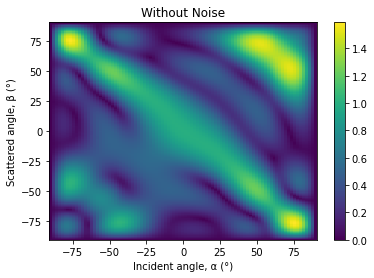

----------------------------------------------------------------------------------------------------


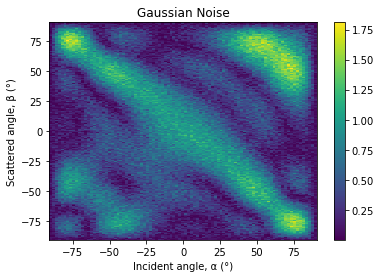

----------------------------------------------------------------------------------------------------


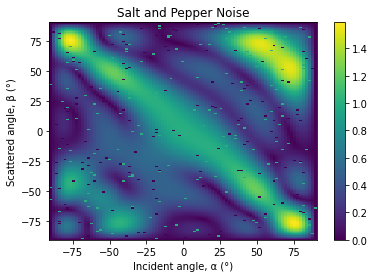

----------------------------------------------------------------------------------------------------


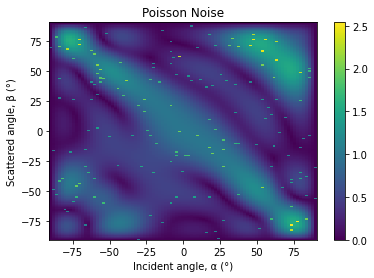

----------------------------------------------------------------------------------------------------


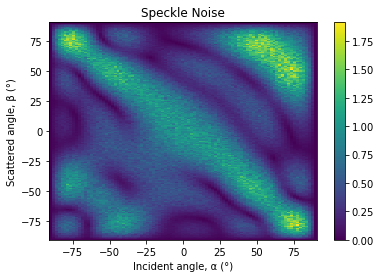

----------------------------------------------------------------------------------------------------


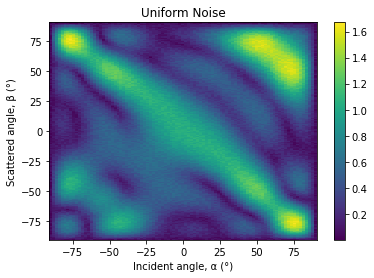

In [33]:
sc_5mhz = X_test_abs
phi1 = f1['phi1']
phi2 = f1['phi2']

tmp = sc_5mhz[0,:,:] 

fig, ax = plt.subplots()
c = ax.pcolor(phi1[:,0]/np.pi*180, phi2[:,0]/np.pi*180, abs(tmp), shading='auto') 
ax.set_xlabel('Incident angle, \u03B1 (\xb0)')
ax.set_ylabel('Scattered angle, \u03B2 (\xb0)')
fig.colorbar(c, ax=ax)
plt.title('Without Noise')
plt.show()

print('-'*100)

sc_5mhz = X_test_abs_gn
phi1 = f1['phi1']
phi2 = f1['phi2']

tmp = sc_5mhz[0,:,:] 

fig, ax = plt.subplots()
c = ax.pcolor(phi1[:,0]/np.pi*180, phi2[:,0]/np.pi*180, abs(tmp), shading='auto') 
ax.set_xlabel('Incident angle, \u03B1 (\xb0)')
ax.set_ylabel('Scattered angle, \u03B2 (\xb0)')
fig.colorbar(c, ax=ax)
plt.title('Gaussian Noise')
plt.show()

print('-'*100)

sc_5mhz = X_test_abs_spn
phi1 = f1['phi1']
phi2 = f1['phi2']

tmp = sc_5mhz[0,:,:] 

fig, ax = plt.subplots()
c = ax.pcolor(phi1[:,0]/np.pi*180, phi2[:,0]/np.pi*180, abs(tmp), shading='auto') 
ax.set_xlabel('Incident angle, \u03B1 (\xb0)')
ax.set_ylabel('Scattered angle, \u03B2 (\xb0)')
fig.colorbar(c, ax=ax)
plt.title('Salt and Pepper Noise')
plt.show()

print('-'*100)

sc_5mhz = X_test_abs_pn
phi1 = f1['phi1']
phi2 = f1['phi2']

tmp = sc_5mhz[0,:,:] 

fig, ax = plt.subplots()
c = ax.pcolor(phi1[:,0]/np.pi*180, phi2[:,0]/np.pi*180, abs(tmp), shading='auto') 
ax.set_xlabel('Incident angle, \u03B1 (\xb0)')
ax.set_ylabel('Scattered angle, \u03B2 (\xb0)')
fig.colorbar(c, ax=ax)
plt.title('Poisson Noise')
plt.show()

print('-'*100)

sc_5mhz = X_test_abs_sn
phi1 = f1['phi1']
phi2 = f1['phi2']

tmp = sc_5mhz[0,:,:] 

fig, ax = plt.subplots()
c = ax.pcolor(phi1[:,0]/np.pi*180, phi2[:,0]/np.pi*180, abs(tmp), shading='auto') 
ax.set_xlabel('Incident angle, \u03B1 (\xb0)')
ax.set_ylabel('Scattered angle, \u03B2 (\xb0)')
fig.colorbar(c, ax=ax)
plt.title('Speckle Noise')
plt.show()

print('-'*100)

sc_5mhz = X_test_abs_un
phi1 = f1['phi1']
phi2 = f1['phi2']

tmp = sc_5mhz[0,:,:] 

fig, ax = plt.subplots()
c = ax.pcolor(phi1[:,0]/np.pi*180, phi2[:,0]/np.pi*180, abs(tmp), shading='auto') 
ax.set_xlabel('Incident angle, \u03B1 (\xb0)')
ax.set_ylabel('Scattered angle, \u03B2 (\xb0)')
fig.colorbar(c, ax=ax)
plt.title('Uniform Noise')
plt.show()

## 2.4. Convolutional Neural Networks (CNN)

In [34]:
inputs = tf.keras.Input(shape = (179, 91, 1))

# model1
x1 = tf.keras.layers.ZeroPadding2D(padding=((0,1),(0,2)))(inputs)
x1 = tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPool2D()(x1)
x1 = tf.keras.layers.Conv2D(filters=4, kernel_size=(3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPool2D()(x1)
x1 = tf.keras.layers.Flatten()(x1)
x1 = tf.keras.layers.Dense(128, activation='relu')(x1)
x1 = tf.keras.layers.Dense(32, activation='relu')(x1)

outputs_x1 = tf.keras.layers.Dense(1, name='Defect_Angles', activation = 'linear')(x1)

# model2
x2 = tf.keras.layers.ZeroPadding2D(padding=((0,1),(0,2)))(inputs)
x2 = tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(x2)
x2 = tf.keras.layers.MaxPool2D()(x2)
x2 = tf.keras.layers.Conv2D(filters=4, kernel_size=(3, 3), activation='relu')(x2)
x2 = tf.keras.layers.MaxPool2D()(x2)
x2 = tf.keras.layers.Flatten()(x2)
x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
x2 = tf.keras.layers.Dense(32, activation='relu')(x2)

outputs_x2 = tf.keras.layers.Dense(1, name='Defect_Sizes', activation='linear')(x2)

# model
model_2_5_MHz = tf.keras.Model(inputs=inputs, outputs=[outputs_x1, outputs_x2], name='model_2_5_MHz')

# compile
model_2_5_MHz.compile(
    optimizer='adam', #adam
    loss={'Defect_Angles': 'mse', 'Defect_Sizes': 'mse'},
    metrics={'Defect_Angles': tf.keras.metrics.MeanSquaredError(),
             'Defect_Sizes': tf.keras.metrics.MeanSquaredError()}
)

# summary
model_2_5_MHz.summary()

Model: "model_2_5_MHz"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 179, 91, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 180, 93, 1)  0           ['input_1[0][0]']                
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 180, 93, 1)  0           ['input_1[0][0]']                
 D)                                                                                               
                                                                                      

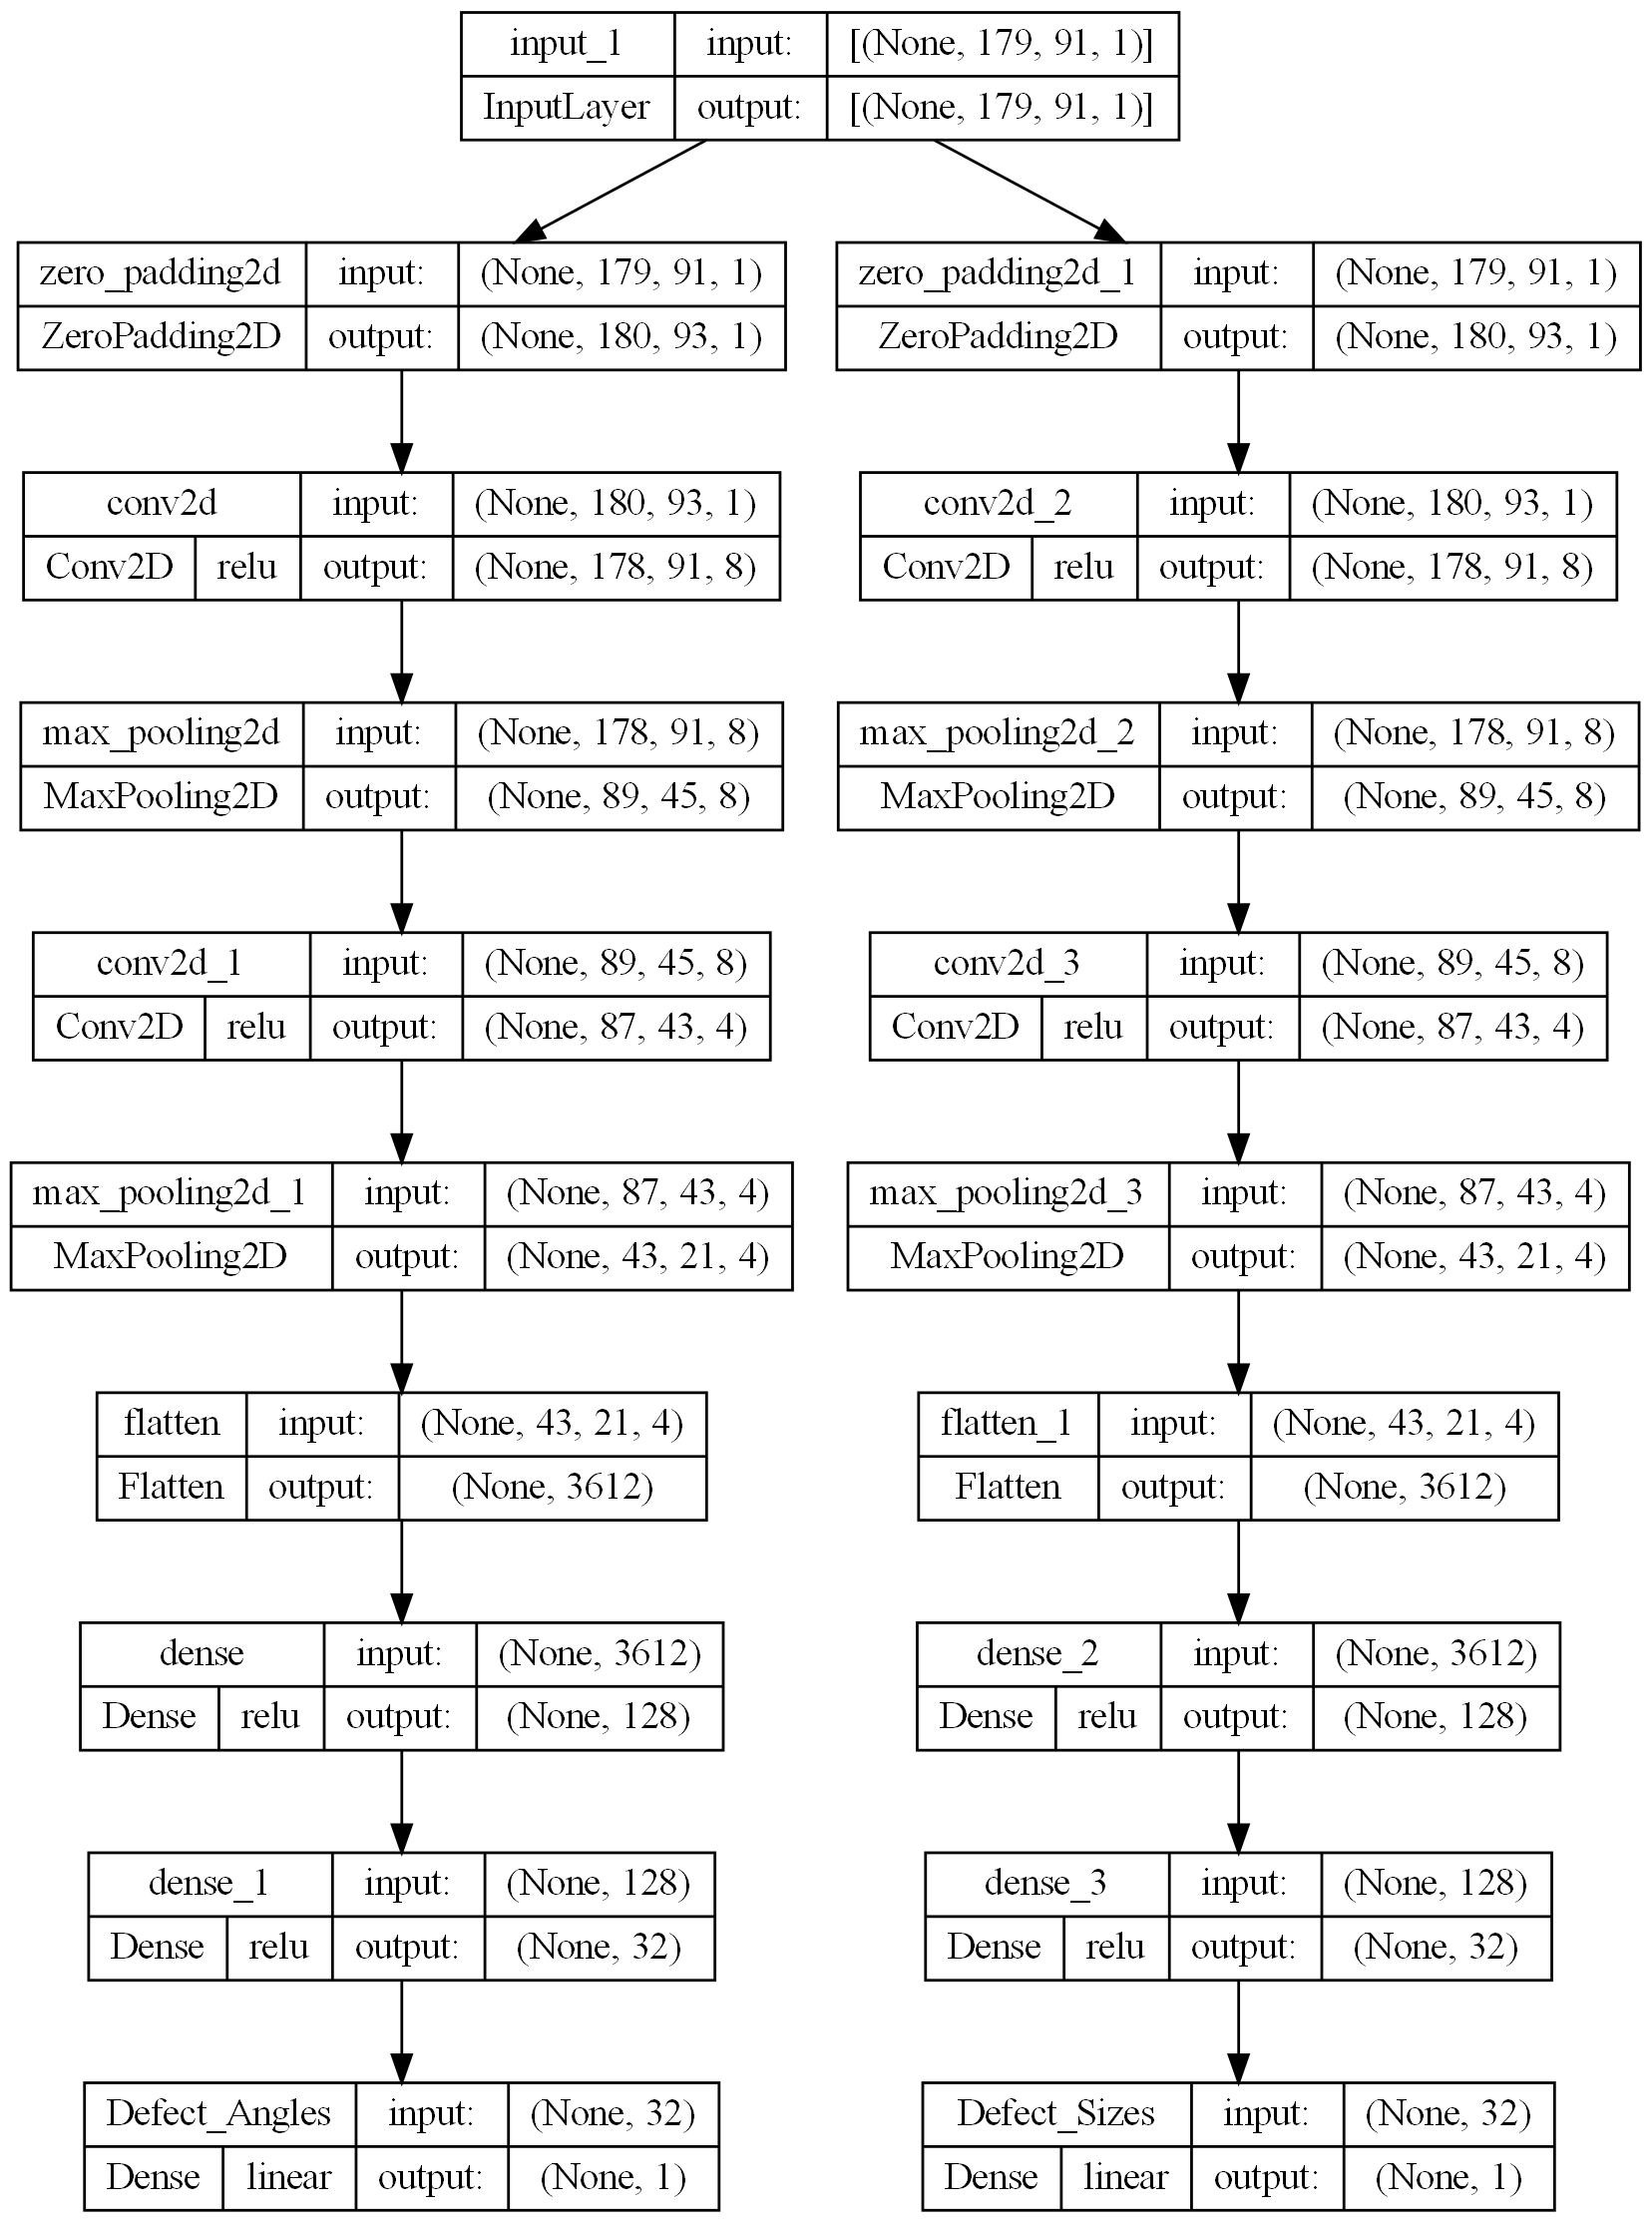

In [35]:
tf.keras.utils.plot_model(model_2_5_MHz,
    to_file = 'D:\\model.png',
    show_shapes = True,
    show_dtype = False,
    show_layer_names = True,
    rankdir = 'TB',
    expand_nested = True,
    dpi = 200,
    layer_range = None,
    show_layer_activations = True)

## 2.5. Training

In [36]:
history_2_5_MHz = model_2_5_MHz.fit(
    X_train_abs,
    [y_train['Defect_Angles'],y_train['Defect_Sizes']],
    validation_data = (X_valid_abs, [y_valid['Defect_Angles'],y_valid['Defect_Sizes']]),
    batch_size = 32,
    epochs = 25,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 5,
            restore_best_weights = True
        )
    ]
)

Epoch 1/25
32/32 [==============================] - 5s 121ms/step - loss: 235.7645 - Defect_Angles_loss: 234.4577 - Defect_Sizes_loss: 1.3068 - Defect_Angles_mean_squared_error: 234.4577 - Defect_Sizes_mean_squared_error: 1.3068 - val_loss: 105.0108 - val_Defect_Angles_loss: 104.9166 - val_Defect_Sizes_loss: 0.0942 - val_Defect_Angles_mean_squared_error: 104.9166 - val_Defect_Sizes_mean_squared_error: 0.0942
Epoch 2/25
32/32 [==============================] - 4s 128ms/step - loss: 44.4174 - Defect_Angles_loss: 44.3711 - Defect_Sizes_loss: 0.0463 - Defect_Angles_mean_squared_error: 44.3711 - Defect_Sizes_mean_squared_error: 0.0463 - val_loss: 33.6290 - val_Defect_Angles_loss: 33.6008 - val_Defect_Sizes_loss: 0.0282 - val_Defect_Angles_mean_squared_error: 33.6008 - val_Defect_Sizes_mean_squared_error: 0.0282
Epoch 3/25
32/32 [==============================] - 3s 101ms/step - loss: 17.7373 - Defect_Angles_loss: 17.7182 - Defect_Sizes_loss: 0.0191 - Defect_Angles_mean_squared_error: 17.718

32/32 [==============================] - 3s 101ms/step - loss: 5.4759 - Defect_Angles_loss: 5.4745 - Defect_Sizes_loss: 0.0014 - Defect_Angles_mean_squared_error: 5.4745 - Defect_Sizes_mean_squared_error: 0.0014 - val_loss: 4.1768 - val_Defect_Angles_loss: 4.1753 - val_Defect_Sizes_loss: 0.0015 - val_Defect_Angles_mean_squared_error: 4.1753 - val_Defect_Sizes_mean_squared_error: 0.0015
Epoch 22/25
32/32 [==============================] - 3s 99ms/step - loss: 5.6374 - Defect_Angles_loss: 5.6361 - Defect_Sizes_loss: 0.0013 - Defect_Angles_mean_squared_error: 5.6361 - Defect_Sizes_mean_squared_error: 0.0013 - val_loss: 4.3360 - val_Defect_Angles_loss: 4.3347 - val_Defect_Sizes_loss: 0.0013 - val_Defect_Angles_mean_squared_error: 4.3347 - val_Defect_Sizes_mean_squared_error: 0.0013
Epoch 23/25
32/32 [==============================] - 3s 100ms/step - loss: 4.6676 - Defect_Angles_loss: 4.6659 - Defect_Sizes_loss: 0.0018 - Defect_Angles_mean_squared_error: 4.6659 - Defect_Sizes_mean_squared_e

## 2.6. Results

In [37]:
# list all data in history
print(history_2_5_MHz.history.keys())

dict_keys(['loss', 'Defect_Angles_loss', 'Defect_Sizes_loss', 'Defect_Angles_mean_squared_error', 'Defect_Sizes_mean_squared_error', 'val_loss', 'val_Defect_Angles_loss', 'val_Defect_Sizes_loss', 'val_Defect_Angles_mean_squared_error', 'val_Defect_Sizes_mean_squared_error'])


In [38]:
# loss
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y = history_2_5_MHz.history['loss'],
                    name = 'Train'))
fig.add_trace(go.Scattergl(
                    y = history_2_5_MHz.history['val_loss'],
                    name = 'Valid'))
fig.update_layout(height = 500, 
                  width = 700,
                  title = 'Overall loss',
                  xaxis_title = 'Epoch',
                  yaxis_title = 'Loss')
fig.show()

In [39]:
def plot_diff(y_true, y_pred, title=''):
    plt.figure(figsize=(8,6))
    plt.scatter(y_true, y_pred, color='red', alpha=0.5)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], lw=3)
    plt.grid()
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.figure(figsize=(6,4))
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history_2_5_MHz.history[metric_name], color='blue', label=metric_name)
    plt.plot(history_2_5_MHz.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.legend()
    plt.grid()
    plt.show()

In [40]:
y_test_2_5_MHz = y_test
y_pred_2_5_MHz = model_2_5_MHz.predict(X_test_abs)
y_pred_2_5_MHz_gn = model_2_5_MHz.predict(X_test_abs_gn)
y_pred_2_5_MHz_spn = model_2_5_MHz.predict(X_test_abs_spn)
y_pred_2_5_MHz_pn = model_2_5_MHz.predict(X_test_abs_pn)
y_pred_2_5_MHz_sn = model_2_5_MHz.predict(X_test_abs_sn)
y_pred_2_5_MHz_un = model_2_5_MHz.predict(X_test_abs_un)

7/7 [==============================] - 0s 29ms/step


In [41]:
np.set_printoptions(suppress=True)

In [42]:
y_pred_2_5_MHz

[array([[-27.287035  ],
        [ 22.378674  ],
        [-11.904278  ],
        [-15.856468  ],
        [ 13.281776  ],
        [ -1.883981  ],
        [  1.6033361 ],
        [ -6.997214  ],
        [-27.73262   ],
        [ -7.593662  ],
        [-18.034588  ],
        [ 12.276941  ],
        [ 21.000538  ],
        [ 17.758495  ],
        [-16.245304  ],
        [ 23.83504   ],
        [-20.873856  ],
        [-29.077503  ],
        [-21.473297  ],
        [-29.921904  ],
        [-28.61874   ],
        [-15.779436  ],
        [ 17.988178  ],
        [ -4.537288  ],
        [-28.084953  ],
        [-16.013224  ],
        [-12.67767   ],
        [  4.2605376 ],
        [ 22.796822  ],
        [  7.4099107 ],
        [-24.123074  ],
        [ 16.668934  ],
        [ 22.285286  ],
        [  0.7307068 ],
        [ 11.295176  ],
        [ 22.971434  ],
        [-29.112984  ],
        [-20.395454  ],
        [ 27.038658  ],
        [ 17.370152  ],
        [ 10.707492  ],
        [  5.586

In [43]:
np.set_printoptions(suppress=False)

In [44]:
y_pred_2_5_MHz = np.hstack((y_pred_2_5_MHz[0], y_pred_2_5_MHz[1]))
#noise
y_pred_2_5_MHz_gn = np.hstack((y_pred_2_5_MHz_gn[0], y_pred_2_5_MHz_gn[1]))
y_pred_2_5_MHz_spn = np.hstack((y_pred_2_5_MHz_spn[0], y_pred_2_5_MHz_spn[1]))
y_pred_2_5_MHz_pn = np.hstack((y_pred_2_5_MHz_pn[0], y_pred_2_5_MHz_pn[1]))
y_pred_2_5_MHz_sn = np.hstack((y_pred_2_5_MHz_sn[0], y_pred_2_5_MHz_sn[1]))
y_pred_2_5_MHz_un = np.hstack((y_pred_2_5_MHz_un[0], y_pred_2_5_MHz_un[1]))

In [45]:
y_pred_2_5_MHz = pd.DataFrame(y_pred_2_5_MHz)
y_pred_2_5_MHz = y_pred_2_5_MHz.rename(columns={0: "Defect_Angles", 1: "Defect_Sizes"})
y_pred_2_5_MHz['Defect_Angles'] = y_pred_2_5_MHz['Defect_Angles'].astype(float)
y_pred_2_5_MHz['Defect_Sizes'] = y_pred_2_5_MHz['Defect_Sizes'].astype(float)

#noise
y_pred_2_5_MHz_gn = pd.DataFrame(y_pred_2_5_MHz_gn)
y_pred_2_5_MHz_gn = y_pred_2_5_MHz_gn.rename(columns={0: "Defect_Angles", 1: "Defect_Sizes"})
y_pred_2_5_MHz_gn['Defect_Angles'] = y_pred_2_5_MHz_gn['Defect_Angles'].astype(float)
y_pred_2_5_MHz_gn['Defect_Sizes'] = y_pred_2_5_MHz_gn['Defect_Sizes'].astype(float)

y_pred_2_5_MHz_spn = pd.DataFrame(y_pred_2_5_MHz_spn)
y_pred_2_5_MHz_spn = y_pred_2_5_MHz_spn.rename(columns={0: "Defect_Angles", 1: "Defect_Sizes"})
y_pred_2_5_MHz_spn['Defect_Angles'] = y_pred_2_5_MHz_spn['Defect_Angles'].astype(float)
y_pred_2_5_MHz_spn['Defect_Sizes'] = y_pred_2_5_MHz_spn['Defect_Sizes'].astype(float)

y_pred_2_5_MHz_pn = pd.DataFrame(y_pred_2_5_MHz_pn)
y_pred_2_5_MHz_pn = y_pred_2_5_MHz_pn.rename(columns={0: "Defect_Angles", 1: "Defect_Sizes"})
y_pred_2_5_MHz_pn['Defect_Angles'] = y_pred_2_5_MHz_pn['Defect_Angles'].astype(float)
y_pred_2_5_MHz_pn['Defect_Sizes'] = y_pred_2_5_MHz_pn['Defect_Sizes'].astype(float)

y_pred_2_5_MHz_sn = pd.DataFrame(y_pred_2_5_MHz_sn)
y_pred_2_5_MHz_sn = y_pred_2_5_MHz_sn.rename(columns={0: "Defect_Angles", 1: "Defect_Sizes"})
y_pred_2_5_MHz_sn['Defect_Angles'] = y_pred_2_5_MHz_sn['Defect_Angles'].astype(float)
y_pred_2_5_MHz_sn['Defect_Sizes'] = y_pred_2_5_MHz_sn['Defect_Sizes'].astype(float)

y_pred_2_5_MHz_un = pd.DataFrame(y_pred_2_5_MHz_un)
y_pred_2_5_MHz_un = y_pred_2_5_MHz_un.rename(columns={0: "Defect_Angles", 1: "Defect_Sizes"})
y_pred_2_5_MHz_un['Defect_Angles'] = y_pred_2_5_MHz_un['Defect_Angles'].astype(float)
y_pred_2_5_MHz_un['Defect_Sizes'] = y_pred_2_5_MHz_un['Defect_Sizes'].astype(float)

### 2.6.1. Defect Angle Results

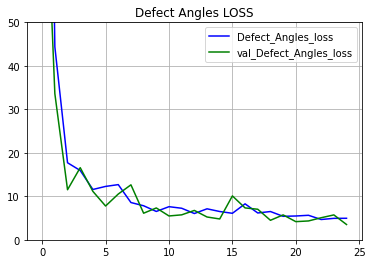

In [46]:
# loss plot
plot_metrics(metric_name='Defect_Angles_loss', title='Defect Angles LOSS', ylim=50)

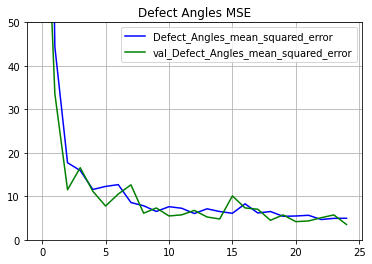

In [47]:
# MSE plot
plot_metrics(metric_name = 'Defect_Angles_mean_squared_error', title='Defect Angles MSE', ylim=50)

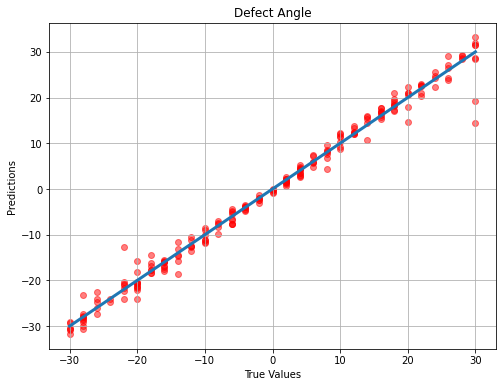

****************************************************************************************************
Gaussian Noise


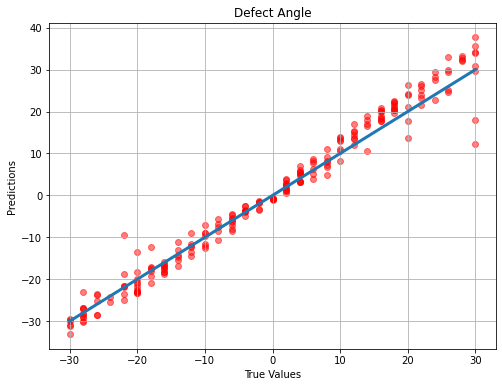

****************************************************************************************************
Salt and Pepper Noise


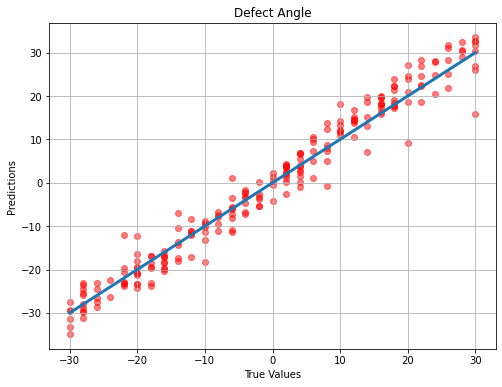

****************************************************************************************************
Poisson Noise


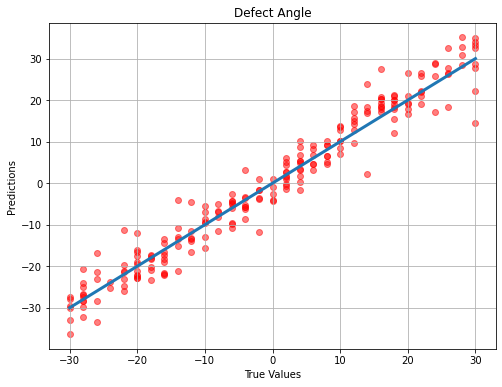

****************************************************************************************************
Speckle Noise


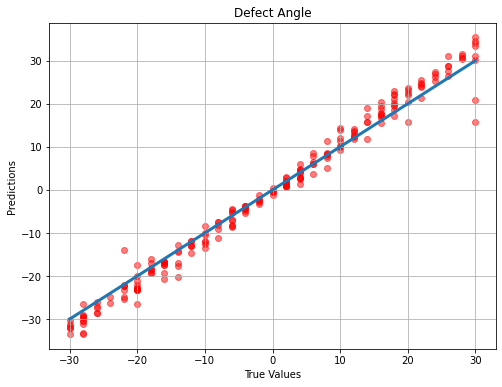

****************************************************************************************************
Uniform Noise


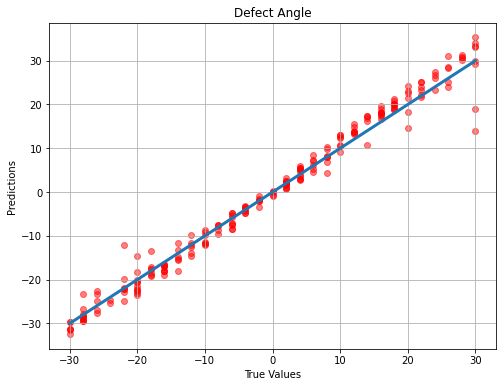

In [48]:
# predictions plot
plot_diff(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz['Defect_Angles'], title='Defect Angle')
#noise
print('*'*100)
print('Gaussian Noise')
plot_diff(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_gn['Defect_Angles'], title='Defect Angle')
print('*'*100)
print('Salt and Pepper Noise')
plot_diff(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_spn['Defect_Angles'], title='Defect Angle')
print('*'*100)
print('Poisson Noise')
plot_diff(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_pn['Defect_Angles'], title='Defect Angle')
print('*'*100)
print('Speckle Noise')
plot_diff(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_sn['Defect_Angles'], title='Defect Angle')
print('*'*100)
print('Uniform Noise')
plot_diff(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_un['Defect_Angles'], title='Defect Angle')

In [49]:
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz['Defect_Angles'], squared = True)
print('Defect Angle Mean Squared Error (MSE): {:0.5f}'.format(mse))

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz['Defect_Angles'], squared = False)
print('Defect Angle Root Mean Squared Error (RMSE): {:0.5f}'.format(rmse))

# Mean Absolute Error (RMSE)
mae = mean_absolute_error(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz['Defect_Angles'])
print('Defect Angle Mean Absolute Error (MAE): {:0.5f}'.format(mae))

# R^2 Score
r2 = r2_score(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz['Defect_Angles'])
print("Defect Angle R^2 Score: {:.5f}".format(r2))

print('*'*100)
print('Gaussian Noise')
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_gn['Defect_Angles'], squared = True)
print('Defect Angle Mean Squared Error (MSE): {:0.5f}'.format(mse))

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_gn['Defect_Angles'], squared = False)
print('Defect Angle Root Mean Squared Error (RMSE): {:0.5f}'.format(rmse))

# Mean Absolute Error (RMSE)
mae = mean_absolute_error(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_gn['Defect_Angles'])
print('Defect Angle Mean Absolute Error (MAE): {:0.5f}'.format(mae))

# R^2 Score
r2 = r2_score(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_gn['Defect_Angles'])
print("Defect Angle R^2 Score: {:.5f}".format(r2))

print('*'*100)
print('Salt and Pepper Noise')
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_spn['Defect_Angles'], squared = True)
print('Defect Angle Mean Squared Error (MSE): {:0.5f}'.format(mse))

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_spn['Defect_Angles'], squared = False)
print('Defect Angle Root Mean Squared Error (RMSE): {:0.5f}'.format(rmse))

# Mean Absolute Error (RMSE)
mae = mean_absolute_error(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_spn['Defect_Angles'])
print('Defect Angle Mean Absolute Error (MAE): {:0.5f}'.format(mae))

# R^2 Score
r2 = r2_score(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_spn['Defect_Angles'])
print("Defect Angle R^2 Score: {:.5f}".format(r2))

print('*'*100)
print('Poisson Noise')
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_pn['Defect_Angles'], squared = True)
print('Defect Angle Mean Squared Error (MSE): {:0.5f}'.format(mse))

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_pn['Defect_Angles'], squared = False)
print('Defect Angle Root Mean Squared Error (RMSE): {:0.5f}'.format(rmse))

# Mean Absolute Error (RMSE)
mae = mean_absolute_error(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_pn['Defect_Angles'])
print('Defect Angle Mean Absolute Error (MAE): {:0.5f}'.format(mae))

# R^2 Score
r2 = r2_score(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_pn['Defect_Angles'])
print("Defect Angle R^2 Score: {:.5f}".format(r2))

print('*'*100)
print('Speckle Noise')
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_sn['Defect_Angles'], squared = True)
print('Defect Angle Mean Squared Error (MSE): {:0.5f}'.format(mse))

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_sn['Defect_Angles'], squared = False)
print('Defect Angle Root Mean Squared Error (RMSE): {:0.5f}'.format(rmse))

# Mean Absolute Error (RMSE)
mae = mean_absolute_error(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_sn['Defect_Angles'])
print('Defect Angle Mean Absolute Error (MAE): {:0.5f}'.format(mae))

# R^2 Score
r2 = r2_score(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_sn['Defect_Angles'])
print("Defect Angle R^2 Score: {:.5f}".format(r2))

print('*'*100)
print('Uniform Noise')
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_un['Defect_Angles'], squared = True)
print('Defect Angle Mean Squared Error (MSE): {:0.5f}'.format(mse))

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_un['Defect_Angles'], squared = False)
print('Defect Angle Root Mean Squared Error (RMSE): {:0.5f}'.format(rmse))

# Mean Absolute Error (RMSE)
mae = mean_absolute_error(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_un['Defect_Angles'])
print('Defect Angle Mean Absolute Error (MAE): {:0.5f}'.format(mae))

# R^2 Score
r2 = r2_score(y_test_2_5_MHz['Defect_Angles'], y_pred_2_5_MHz_un['Defect_Angles'])
print("Defect Angle R^2 Score: {:.5f}".format(r2))

Defect Angle Mean Squared Error (MSE): 4.03006
Defect Angle Root Mean Squared Error (RMSE): 2.00750
Defect Angle Mean Absolute Error (MAE): 1.20878
Defect Angle R^2 Score: 0.98646
****************************************************************************************************
Gaussian Noise
Defect Angle Mean Squared Error (MSE): 9.12829
Defect Angle Root Mean Squared Error (RMSE): 3.02131
Defect Angle Mean Absolute Error (MAE): 2.13011
Defect Angle R^2 Score: 0.96934
****************************************************************************************************
Salt and Pepper Noise
Defect Angle Mean Squared Error (MSE): 11.16937
Defect Angle Root Mean Squared Error (RMSE): 3.34206
Defect Angle Mean Absolute Error (MAE): 2.56057
Defect Angle R^2 Score: 0.96248
****************************************************************************************************
Poisson Noise
Defect Angle Mean Squared Error (MSE): 14.66538
Defect Angle Root Mean Squared Error (RMSE): 3.82954
Defe

In [50]:
# defect angle true values
pd.Series(y_test_2_5_MHz['Defect_Angles']).describe()

count    214.000000
mean      -0.598131
std       17.294391
min      -30.000000
25%      -16.000000
50%        0.000000
75%       14.000000
max       30.000000
Name: Defect_Angles, dtype: float64

In [51]:
# defect angle predictions
print(pd.Series(y_pred_2_5_MHz['Defect_Angles']).describe())
# noise
print('*'*100)
print('Gaussian Noise')
print(pd.Series(y_pred_2_5_MHz_gn['Defect_Angles']).describe())
print('*'*100)
print('Salt and Pepper Noise')
print(pd.Series(y_pred_2_5_MHz_spn['Defect_Angles']).describe())
print('*'*100)
print('Poisson Noise')
print(pd.Series(y_pred_2_5_MHz_pn['Defect_Angles']).describe())
print('*'*100)
print('Speckle Noise')
print(pd.Series(y_pred_2_5_MHz_sn['Defect_Angles']).describe())
print('*'*100)
print('Uniform Noise')
print(pd.Series(y_pred_2_5_MHz_un['Defect_Angles']).describe())

count    214.000000
mean      -0.637457
std       17.336269
min      -31.721449
25%      -15.843945
50%       -0.189263
75%       14.401465
max       33.137779
Name: Defect_Angles, dtype: float64
****************************************************************************************************
Gaussian Noise
count    214.000000
mean       0.096852
std       18.364535
min      -33.045837
25%      -16.250954
50%       -0.773848
75%       16.211412
max       37.655178
Name: Defect_Angles, dtype: float64
****************************************************************************************************
Salt and Pepper Noise
count    214.000000
mean      -0.262164
std       18.178339
min      -34.849594
25%      -16.984064
50%       -0.160203
75%       15.693419
max       33.484547
Name: Defect_Angles, dtype: float64
****************************************************************************************************
Poisson Noise
count    214.000000
mean      -0.301511
std       18.02086

In [52]:
y_test_2_5_MHz.reset_index(inplace=True)
y_pred_2_5_MHz.reset_index(inplace=True)
# noise
y_pred_2_5_MHz_gn.reset_index(inplace=True)
y_pred_2_5_MHz_spn.reset_index(inplace=True)
y_pred_2_5_MHz_pn.reset_index(inplace=True)
y_pred_2_5_MHz_sn.reset_index(inplace=True)
y_pred_2_5_MHz_un.reset_index(inplace=True)

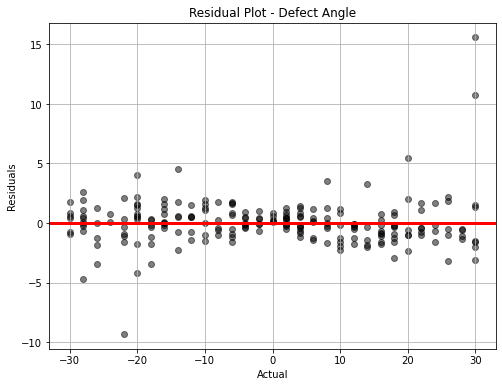

****************************************************************************************************
Gaussian Noise


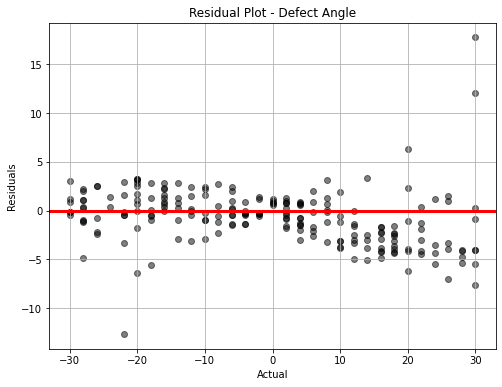

****************************************************************************************************
Salt and Pepper Noise


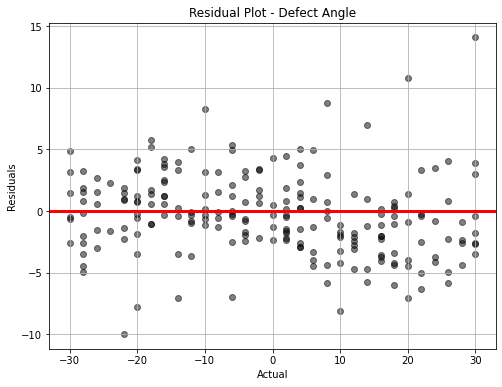

****************************************************************************************************
Poisson Noise


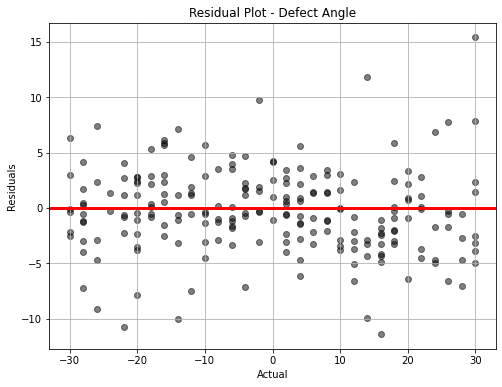

****************************************************************************************************
Speckle Noise


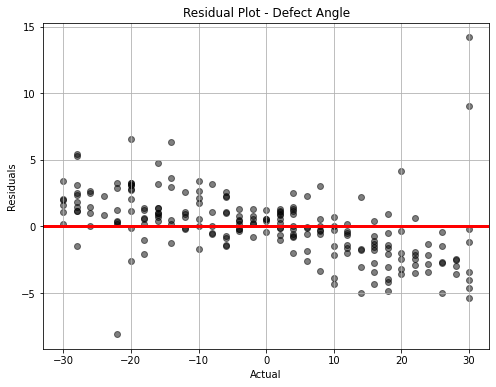

****************************************************************************************************
Uniform Noise


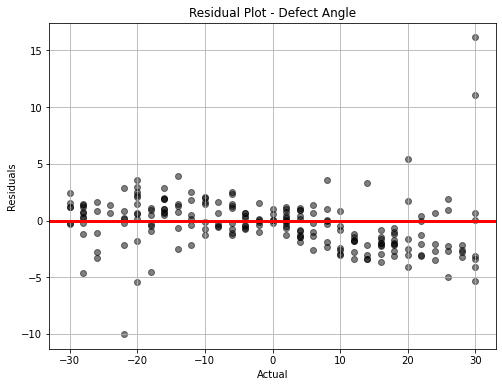

In [53]:
# residual plot
plt.figure(figsize=(8,6))
y = np.linspace(0,3500,100)
x = np.linspace(0,0)
residuals = y_test_2_5_MHz['Defect_Angles'] - y_pred_2_5_MHz['Defect_Angles']
plt.scatter(x = y_test_2_5_MHz['Defect_Angles'], y = residuals, color = 'black', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-', linewidth=3)
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.title('Residual Plot - Defect Angle')
plt.grid()
plt.show()

print('*'*100)
print('Gaussian Noise')
plt.figure(figsize=(8,6))
y = np.linspace(0,3500,100)
x = np.linspace(0,0)
residuals_gn = y_test_2_5_MHz['Defect_Angles'] - y_pred_2_5_MHz_gn['Defect_Angles']
plt.scatter(x = y_test_2_5_MHz['Defect_Angles'], y = residuals_gn, color = 'black', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-', linewidth=3)
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.title('Residual Plot - Defect Angle')
plt.grid()
plt.show()

print('*'*100)
print('Salt and Pepper Noise')
plt.figure(figsize=(8,6))
y = np.linspace(0,3500,100)
x = np.linspace(0,0)
residuals_spn = y_test_2_5_MHz['Defect_Angles'] - y_pred_2_5_MHz_spn['Defect_Angles']
plt.scatter(x = y_test_2_5_MHz['Defect_Angles'], y = residuals_spn, color = 'black', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-', linewidth=3)
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.title('Residual Plot - Defect Angle')
plt.grid()
plt.show()

print('*'*100)
print('Poisson Noise')
plt.figure(figsize=(8,6))
y = np.linspace(0,3500,100)
x = np.linspace(0,0)
residuals_pn = y_test_2_5_MHz['Defect_Angles'] - y_pred_2_5_MHz_pn['Defect_Angles']
plt.scatter(x = y_test_2_5_MHz['Defect_Angles'], y = residuals_pn, color = 'black', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-', linewidth=3)
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.title('Residual Plot - Defect Angle')
plt.grid()
plt.show()

print('*'*100)
print('Speckle Noise')
plt.figure(figsize=(8,6))
y = np.linspace(0,3500,100)
x = np.linspace(0,0)
residuals_sn = y_test_2_5_MHz['Defect_Angles'] - y_pred_2_5_MHz_sn['Defect_Angles']
plt.scatter(x = y_test_2_5_MHz['Defect_Angles'], y = residuals_sn, color = 'black', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-', linewidth=3)
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.title('Residual Plot - Defect Angle')
plt.grid()
plt.show()

print('*'*100)
print('Uniform Noise')
plt.figure(figsize=(8,6))
y = np.linspace(0,3500,100)
x = np.linspace(0,0)
residuals_un = y_test_2_5_MHz['Defect_Angles'] - y_pred_2_5_MHz_un['Defect_Angles']
plt.scatter(x = y_test_2_5_MHz['Defect_Angles'], y = residuals_un, color = 'black', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-', linewidth=3)
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.title('Residual Plot - Defect Angle')
plt.grid()
plt.show()

In [54]:
da_true_2_5_MHz = ((residuals <= 3) & (residuals >= -3))
count = np.count_nonzero(da_true_2_5_MHz)
print('Number of residuals: ', count)
print('Percentage: ', count/214)

#noise
print('*'*100)
print('Gaussian Noise')
da_true_2_5_MHz = ((residuals_gn <= 3) & (residuals_gn >= -3))
count = np.count_nonzero(da_true_2_5_MHz)
print('Number of residuals: ', count)
print('Percentage: ', count/214)

print('*'*100)
print('Salt and Pepper Noise')
da_true_2_5_MHz = ((residuals_spn <= 3) & (residuals_spn >= -3))
count = np.count_nonzero(da_true_2_5_MHz)
print('Number of residuals: ', count)
print('Percentage: ', count/214)

print('*'*100)
print('Poisson Noise')
da_true_2_5_MHz = ((residuals_pn <= 3) & (residuals_pn >= -3))
count = np.count_nonzero(da_true_2_5_MHz)
print('Number of residuals: ', count)
print('Percentage: ', count/214)

print('*'*100)
print('Speckle Noise')
da_true_2_5_MHz = ((residuals_sn <= 3) & (residuals_sn >= -3))
count = np.count_nonzero(da_true_2_5_MHz)
print('Number of residuals: ', count)
print('Percentage: ', count/214)

print('*'*100)
print('Uniform Noise')
da_true_2_5_MHz = ((residuals_un <= 3) & (residuals_un >= -3))
count = np.count_nonzero(da_true_2_5_MHz)
print('Number of residuals: ', count)
print('Percentage: ', count/214)

Number of residuals:  200
Percentage:  0.9345794392523364
****************************************************************************************************
Gaussian Noise
Number of residuals:  159
Percentage:  0.7429906542056075
****************************************************************************************************
Salt and Pepper Noise
Number of residuals:  138
Percentage:  0.6448598130841121
****************************************************************************************************
Poisson Noise
Number of residuals:  136
Percentage:  0.6355140186915887
****************************************************************************************************
Speckle Noise
Number of residuals:  172
Percentage:  0.8037383177570093
****************************************************************************************************
Uniform Noise
Number of residuals:  185
Percentage:  0.8644859813084113


### 2.6.2. Defect Sizes Results

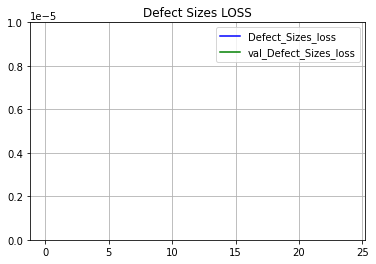

In [55]:
plot_metrics(metric_name='Defect_Sizes_loss', title='Defect Sizes LOSS', ylim=0.00001)

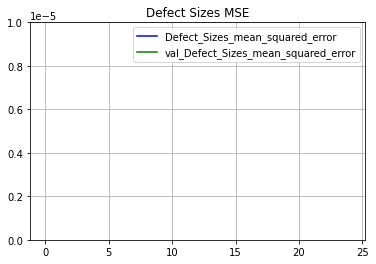

In [56]:
plot_metrics(metric_name = 'Defect_Sizes_mean_squared_error', title='Defect Sizes MSE', ylim=0.00001)

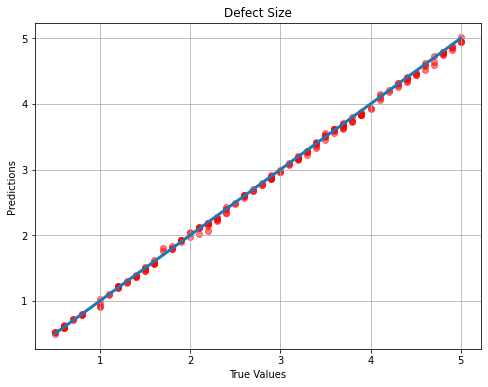

****************************************************************************************************
Gaussian Noise


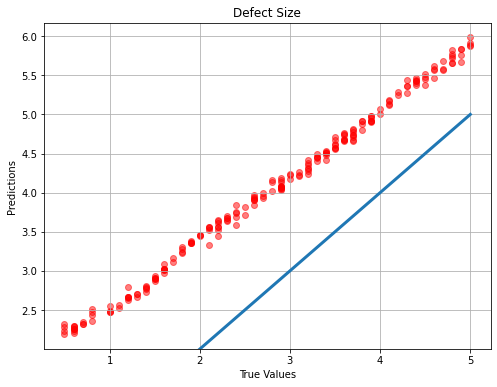

****************************************************************************************************
Salt and Pepper Noise


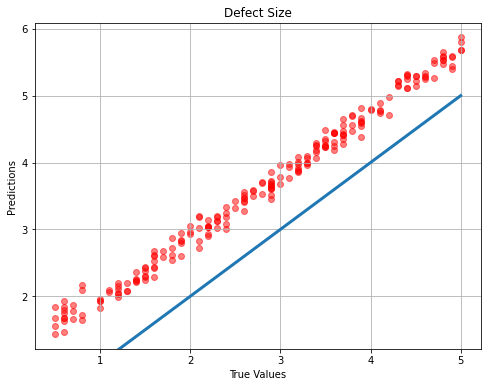

****************************************************************************************************
Poisson Noise


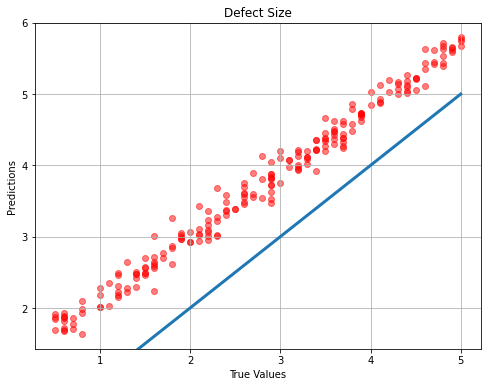

****************************************************************************************************
Speckle Noise


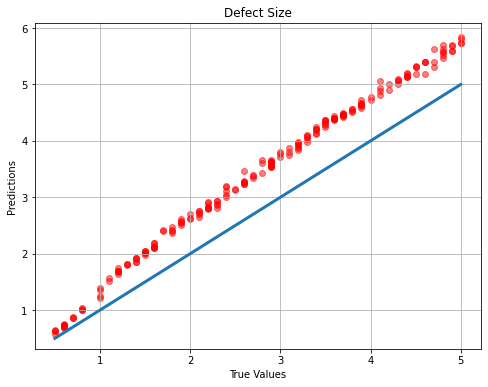

****************************************************************************************************
Uniform Noise


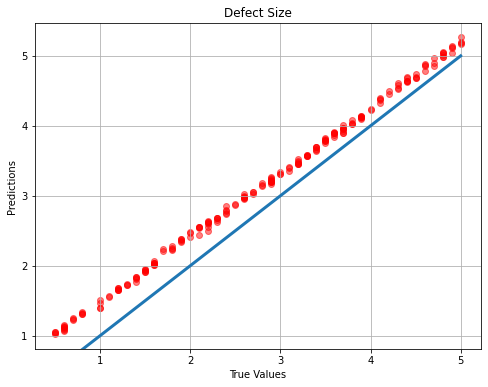

In [57]:
plot_diff(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz['Defect_Sizes'], title='Defect Size')
#noise
print('*'*100)
print('Gaussian Noise')
plot_diff(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_gn['Defect_Sizes'], title='Defect Size')
print('*'*100)
print('Salt and Pepper Noise')
plot_diff(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_spn['Defect_Sizes'], title='Defect Size')
print('*'*100)
print('Poisson Noise')
plot_diff(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_pn['Defect_Sizes'], title='Defect Size')
print('*'*100)
print('Speckle Noise')
plot_diff(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_sn['Defect_Sizes'], title='Defect Size')
print('*'*100)
print('Uniform Noise')
plot_diff(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_un['Defect_Sizes'], title='Defect Size')

In [58]:
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz['Defect_Sizes'], squared = True)
print('Defect Size Mean Squared Error (MSE): {:0.5f}'.format(mse))

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz['Defect_Sizes'], squared = False)
print('Defect Size Root Mean Squared Error (RMSE): {:0.5f}'.format(rmse))

# Mean Absolute Error (RMSE)
mae = mean_absolute_error(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz['Defect_Sizes'])
print('Defect Size Mean Absolute Error (MAE): {:0.5f}'.format(mae))

# R^2 Score
r2 = r2_score(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz['Defect_Sizes'])
print("Defect Size R^2 Score: {:.5f}".format(r2))

print('*'*100)
print('Gaussian Noise')
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_gn['Defect_Sizes'], squared = True)
print('Defect Size Mean Squared Error (MSE): {:0.5f}'.format(mse))

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_gn['Defect_Sizes'], squared = False)
print('Defect Size Root Mean Squared Error (RMSE): {:0.5f}'.format(rmse))

# Mean Absolute Error (RMSE)
mae = mean_absolute_error(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_gn['Defect_Sizes'])
print('Defect Size Mean Absolute Error (MAE): {:0.5f}'.format(mae))

# R^2 Score
r2 = r2_score(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_gn['Defect_Sizes'])
print("Defect Size R^2 Score: {:.5f}".format(r2))

print('*'*100)
print('Salt and Pepper Noise')
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_spn['Defect_Sizes'], squared = True)
print('Defect Size Mean Squared Error (MSE): {:0.5f}'.format(mse))

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_spn['Defect_Sizes'], squared = False)
print('Defect Size Root Mean Squared Error (RMSE): {:0.5f}'.format(rmse))

# Mean Absolute Error (RMSE)
mae = mean_absolute_error(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_spn['Defect_Sizes'])
print('Defect Size Mean Absolute Error (MAE): {:0.5f}'.format(mae))

# R^2 Score
r2 = r2_score(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_spn['Defect_Sizes'])
print("Defect Size R^2 Score: {:.5f}".format(r2))

print('*'*100)
print('Poisson Noise')
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_pn['Defect_Sizes'], squared = True)
print('Defect Size Mean Squared Error (MSE): {:0.5f}'.format(mse))

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_pn['Defect_Sizes'], squared = False)
print('Defect Size Root Mean Squared Error (RMSE): {:0.5f}'.format(rmse))

# Mean Absolute Error (RMSE)
mae = mean_absolute_error(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_pn['Defect_Sizes'])
print('Defect Size Mean Absolute Error (MAE): {:0.5f}'.format(mae))

# R^2 Score
r2 = r2_score(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_pn['Defect_Sizes'])
print("Defect Size R^2 Score: {:.5f}".format(r2))

print('*'*100)
print('Speckle Noise')
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_sn['Defect_Sizes'], squared = True)
print('Defect Size Mean Squared Error (MSE): {:0.5f}'.format(mse))

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_sn['Defect_Sizes'], squared = False)
print('Defect Size Root Mean Squared Error (RMSE): {:0.5f}'.format(rmse))

# Mean Absolute Error (RMSE)
mae = mean_absolute_error(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_sn['Defect_Sizes'])
print('Defect Size Mean Absolute Error (MAE): {:0.5f}'.format(mae))

# R^2 Score
r2 = r2_score(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_sn['Defect_Sizes'])
print("Defect Size R^2 Score: {:.5f}".format(r2))

print('*'*100)
print('Uniform Noise')
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_un['Defect_Sizes'], squared = True)
print('Defect Size Mean Squared Error (MSE): {:0.5f}'.format(mse))

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_un['Defect_Sizes'], squared = False)
print('Defect Size Root Mean Squared Error (RMSE): {:0.5f}'.format(rmse))

# Mean Absolute Error (RMSE)
mae = mean_absolute_error(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_un['Defect_Sizes'])
print('Defect Size Mean Absolute Error (MAE): {:0.5f}'.format(mae))

# R^2 Score
r2 = r2_score(y_test_2_5_MHz['Defect_Sizes'], y_pred_2_5_MHz_un['Defect_Sizes'])
print("Defect Size R^2 Score: {:.5f}".format(r2))

Defect Size Mean Squared Error (MSE): 0.00141
Defect Size Root Mean Squared Error (RMSE): 0.03751
Defect Size Mean Absolute Error (MAE): 0.02932
Defect Size R^2 Score: 0.99913
****************************************************************************************************
Gaussian Noise
Defect Size Mean Squared Error (MSE): 1.60139
Defect Size Root Mean Squared Error (RMSE): 1.26546
Defect Size Mean Absolute Error (MAE): 1.24527
Defect Size R^2 Score: 0.00965
****************************************************************************************************
Salt and Pepper Noise
Defect Size Mean Squared Error (MSE): 0.71440
Defect Size Root Mean Squared Error (RMSE): 0.84522
Defect Size Mean Absolute Error (MAE): 0.83176
Defect Size R^2 Score: 0.55819
****************************************************************************************************
Poisson Noise
Defect Size Mean Squared Error (MSE): 0.90502
Defect Size Root Mean Squared Error (RMSE): 0.95132
Defect Size Mean Abs

In [59]:
# defect size true values
pd.Series(y_test_2_5_MHz['Defect_Sizes']).describe()

count    214.000000
mean       2.796262
std        1.274593
min        0.500000
25%        1.725000
50%        2.900000
75%        3.775000
max        5.000000
Name: Defect_Sizes, dtype: float64

In [60]:
# defect size predictions
pd.Series(y_pred_2_5_MHz['Defect_Sizes']).describe()

# noise
print('*'*100)
print('Gaussian Noise')
print(pd.Series(y_pred_2_5_MHz_gn['Defect_Sizes']).describe())
print('*'*100)
print('Salt and Pepper Noise')
print(pd.Series(y_pred_2_5_MHz_spn['Defect_Sizes']).describe())
print('*'*100)
print('Poisson Noise')
print(pd.Series(y_pred_2_5_MHz_pn['Defect_Sizes']).describe())
print('*'*100)
print('Speckle Noise')
print(pd.Series(y_pred_2_5_MHz_sn['Defect_Sizes']).describe())
print('*'*100)
print('Uniform Noise')
print(pd.Series(y_pred_2_5_MHz_un['Defect_Sizes']).describe())

****************************************************************************************************
Gaussian Noise
count    214.000000
mean       4.041536
std        1.060768
min        2.193300
25%        3.181322
50%        4.076769
75%        4.807828
max        5.983531
Name: Defect_Sizes, dtype: float64
****************************************************************************************************
Salt and Pepper Noise
count    214.000000
mean       3.628025
std        1.188879
min        1.438039
25%        2.614999
50%        3.661513
75%        4.533666
max        5.869456
Name: Defect_Sizes, dtype: float64
****************************************************************************************************
Poisson Noise
count    214.000000
mean       3.727513
std        1.149392
min        1.634878
25%        2.785358
50%        3.811501
75%        4.620581
max        5.794241
Name: Defect_Sizes, dtype: float64
*************************************************************

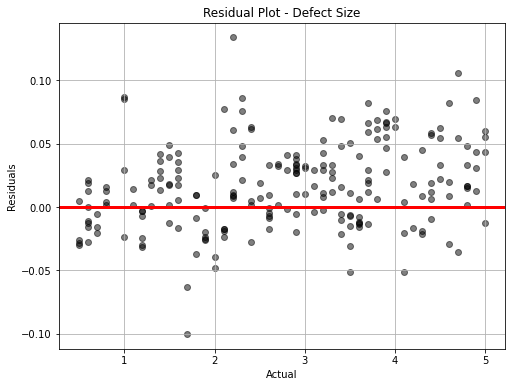

****************************************************************************************************
Gaussian Noise


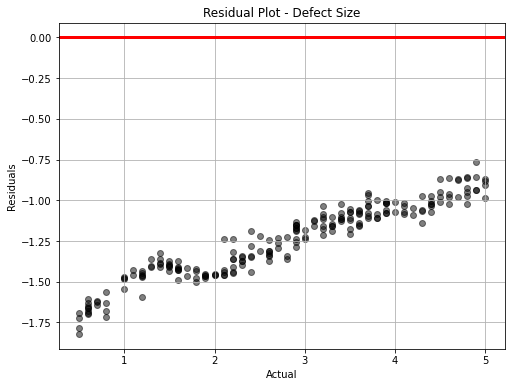

****************************************************************************************************
Salt and Pepper Noise


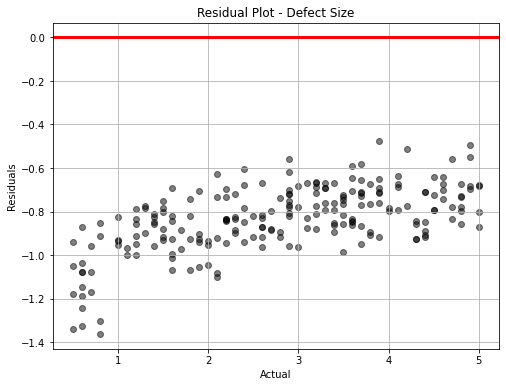

****************************************************************************************************
Poisson Noise


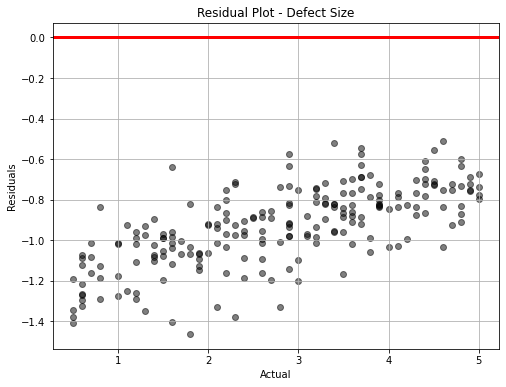

****************************************************************************************************
Speckle Noise


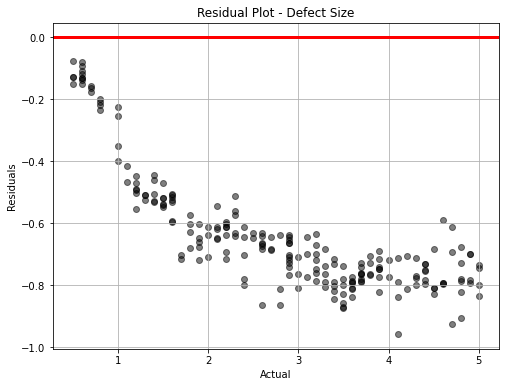

****************************************************************************************************
Uniform Noise


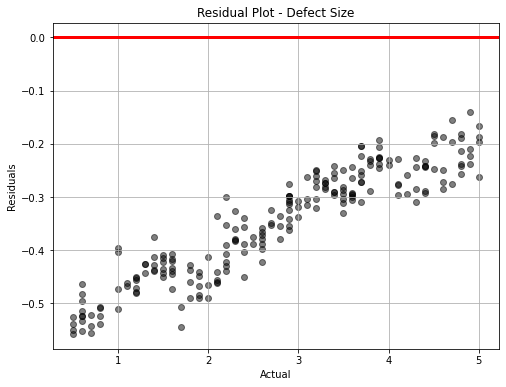

In [61]:
# residual plot
plt.figure(figsize=(8,6))
y = np.linspace(0,3500,100)
x = np.linspace(0,0)
residuals = y_test_2_5_MHz['Defect_Sizes'] - y_pred_2_5_MHz['Defect_Sizes']
plt.scatter(x = y_test_2_5_MHz['Defect_Sizes'], y = residuals, color = 'black', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-', linewidth=3)
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.title('Residual Plot - Defect Size')
plt.grid()
plt.show()

# noise
print('*'*100)
print('Gaussian Noise')
plt.figure(figsize=(8,6))
y = np.linspace(0,3500,100)
x = np.linspace(0,0)
residuals_gn = y_test_2_5_MHz['Defect_Sizes'] - y_pred_2_5_MHz_gn['Defect_Sizes']
plt.scatter(x = y_test_2_5_MHz['Defect_Sizes'], y = residuals_gn, color = 'black', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-', linewidth=3)
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.title('Residual Plot - Defect Size')
plt.grid()
plt.show()

print('*'*100)
print('Salt and Pepper Noise')
plt.figure(figsize=(8,6))
y = np.linspace(0,3500,100)
x = np.linspace(0,0)
residuals_spn = y_test_2_5_MHz['Defect_Sizes'] - y_pred_2_5_MHz_spn['Defect_Sizes']
plt.scatter(x = y_test_2_5_MHz['Defect_Sizes'], y = residuals_spn, color = 'black', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-', linewidth=3)
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.title('Residual Plot - Defect Size')
plt.grid()
plt.show()

print('*'*100)
print('Poisson Noise')
plt.figure(figsize=(8,6))
y = np.linspace(0,3500,100)
x = np.linspace(0,0)
residuals_pn = y_test_2_5_MHz['Defect_Sizes'] - y_pred_2_5_MHz_pn['Defect_Sizes']
plt.scatter(x = y_test_2_5_MHz['Defect_Sizes'], y = residuals_pn, color = 'black', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-', linewidth=3)
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.title('Residual Plot - Defect Size')
plt.grid()
plt.show()

print('*'*100)
print('Speckle Noise')
plt.figure(figsize=(8,6))
y = np.linspace(0,3500,100)
x = np.linspace(0,0)
residuals_sn = y_test_2_5_MHz['Defect_Sizes'] - y_pred_2_5_MHz_sn['Defect_Sizes']
plt.scatter(x = y_test_2_5_MHz['Defect_Sizes'], y = residuals_sn, color = 'black', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-', linewidth=3)
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.title('Residual Plot - Defect Size')
plt.grid()
plt.show()

print('*'*100)
print('Uniform Noise')
plt.figure(figsize=(8,6))
y = np.linspace(0,3500,100)
x = np.linspace(0,0)
residuals_un = y_test_2_5_MHz['Defect_Sizes'] - y_pred_2_5_MHz_un['Defect_Sizes']
plt.scatter(x = y_test_2_5_MHz['Defect_Sizes'], y = residuals_un, color = 'black', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-', linewidth=3)
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.title('Residual Plot - Defect Size')
plt.grid()
plt.show()

In [63]:
ds_true_2_5_MHz = ((residuals<= 0.002) & (residuals >= -0.002))
count = np.count_nonzero(ds_true_2_5_MHz)
print('Number of residuals: ', count)
print('Percentage: ', count/214)

#noise
print('*'*100)
print('Gaussian Noise')
ds_true_2_5_MHz = ((residuals_gn <= 0.002) & (residuals_gn >= -0.002))
count = np.count_nonzero(ds_true_2_5_MHz)
print('Number of residuals: ', count)
print('Percentage: ', count/214)

print('*'*100)
print('Salt and Pepper Noise')
ds_true_2_5_MHz = ((residuals_spn <= 0.002) & (residuals_spn >= -0.002))
count = np.count_nonzero(ds_true_2_5_MHz)
print('Number of residuals: ', count)
print('Percentage: ', count/214)

print('*'*100)
print('Poisson Noise')
ds_true_2_5_MHz = ((residuals_pn <= 0.002) & (residuals_pn >= -0.002))
count = np.count_nonzero(ds_true_2_5_MHz)
print('Number of residuals: ', count)
print('Percentage: ', count/214)

print('*'*100)
print('Speckle Noise')
ds_true_2_5_MHz = ((residuals_sn <= 0.002) & (residuals_sn >= -0.002))
count = np.count_nonzero(ds_true_2_5_MHz)
print('Number of residuals: ', count)
print('Percentage: ', count/214)

print('*'*100)
print('Uniform Noise')
ds_true_2_5_MHz = ((residuals_un <= 0.002) & (residuals_un >= -0.002))
count = np.count_nonzero(ds_true_2_5_MHz)
print('Number of residuals: ', count)
print('Percentage: ', count/214)

Number of residuals:  214
Percentage:  1.0
****************************************************************************************************
Gaussian Noise
Number of residuals:  0
Percentage:  0.0
****************************************************************************************************
Salt and Pepper Noise
Number of residuals:  0
Percentage:  0.0
****************************************************************************************************
Poisson Noise
Number of residuals:  0
Percentage:  0.0
****************************************************************************************************
Speckle Noise
Number of residuals:  0
Percentage:  0.0
****************************************************************************************************
Uniform Noise
Number of residuals:  0
Percentage:  0.0
